# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" published in **IEEE International Conference on Communications (IEEE ICC)**, doi=[10.1109/ICC45855.2022.9838780](https://ieeexplore.ieee.org/document/9838780).    
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 2: CNN Model Development**  
Aims:  
&nbsp; 1): Generate training and test images  
&nbsp; 2): Construct CNN models (a CNN model by own, Xception, VGG16, VGG19, Resnet, Inception, InceptionResnet)  
&nbsp; 3): Tune the hyperparameters of CNN models (hyperparameter optimization)  

## Import libraries

In [2]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

## Generate Training and Test Images

In [3]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 23382 images belonging to 5 classes.
Found 5845 images belonging to 5 classes.


### Define the image plotting functions

In [4]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [5]:
history_this= LossHistory()

# Construct CNN models

### Model 1: a CNN model by own (baseline)

In [5]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )

Epoch 1/20
183/183 [==============================] - 303s 2s/step - loss: 0.0585 - acc: 0.9785 - val_loss: 0.0040 - val_acc: 0.9988
Epoch 2/20
183/183 [==============================] - 125s 685ms/step - loss: 0.0293 - acc: 0.9883 - val_loss: 0.0204 - val_acc: 0.9883
Epoch 3/20
183/183 [==============================] - 126s 686ms/step - loss: 0.0205 - acc: 0.9886 - val_loss: 0.0185 - val_acc: 0.9846
Epoch 00003: early stopping


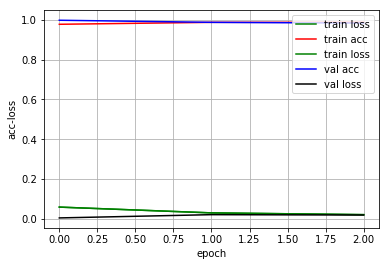

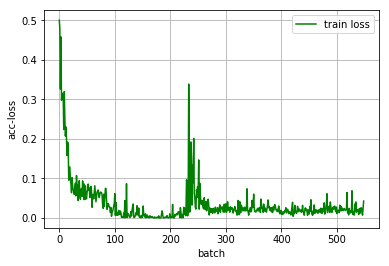

In [7]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of a CNN by own: 99.884%

### Model 2: Xception

In [9]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
183/183 [==============================] - 89s 486ms/step - loss: 0.0542 - acc: 0.9829 - val_loss: 0.1063 - val_acc: 0.9649
Epoch 2/20
183/183 [==============================] - 78s 425ms/step - loss: 0.0017 - acc: 0.9999 - val_loss: 2.4231e-04 - val_acc: 1.0000
Epoch 3/20
183/183 [==============================] - 73s 398ms/step - loss: 7.3384e-04 - acc: 1.0000 - val_loss: 1.2173e-04 - val_acc: 1.0000
Epoch 4/20
183/183 [==============================] - 73s 399ms/step - loss: 9.7122e-04 - acc: 0.9998 - val_loss: 1.1143e-04 - val_acc: 1.0000
Epoch 5/20
183/183 [==============================] - 73s 399ms/step - loss: 9.6497e-04 - acc: 0.9998 - val_loss: 8.3518e-05 - val_acc: 1.0000
Epoch 00005: early stopping


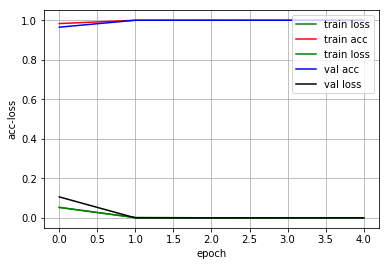

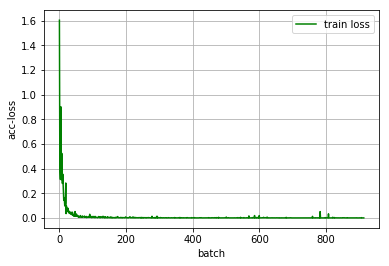

In [10]:
#default only 50, tf36cnn 99
xception(num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Xception: 100.0%

### Model 3: VGG16

In [11]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


Epoch 1/20
183/183 [==============================] - 71s 389ms/step - loss: 0.0398 - acc: 0.9920 - val_loss: 1.0384e-07 - val_acc: 1.0000
Epoch 2/20
183/183 [==============================] - 65s 357ms/step - loss: 1.6802e-05 - acc: 1.0000 - val_loss: 1.0385e-07 - val_acc: 1.0000
Epoch 3/20
183/183 [==============================] - 67s 369ms/step - loss: 2.3990e-07 - acc: 1.0000 - val_loss: 1.0384e-07 - val_acc: 1.0000
Epoch 00003: early stopping


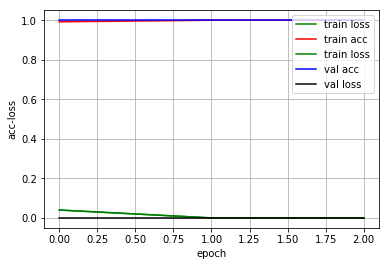

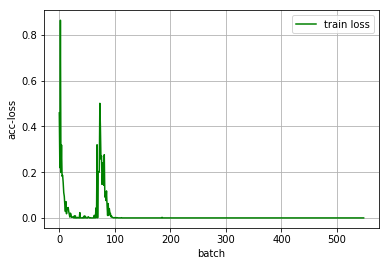

In [12]:
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG16: 100.0%

### Model 4: VGG19

In [13]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )


Epoch 1/20
183/183 [==============================] - 78s 429ms/step - loss: 0.0089 - acc: 0.9968 - val_loss: 1.0405e-07 - val_acc: 1.0000
Epoch 2/20
183/183 [==============================] - 75s 411ms/step - loss: 4.4981e-06 - acc: 1.0000 - val_loss: 1.0396e-07 - val_acc: 1.0000
Epoch 3/20
183/183 [==============================] - 75s 409ms/step - loss: 0.0051 - acc: 0.9992 - val_loss: 1.0384e-07 - val_acc: 1.0000
Epoch 00003: early stopping


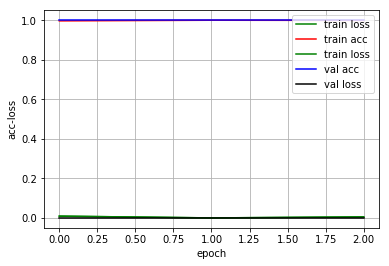

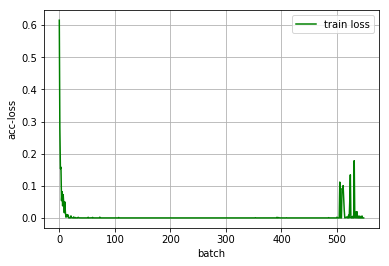

In [14]:
vgg19(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of VGG19: 100.0%

### Model 5: ResNet

In [15]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
183/183 [==============================] - 109s 594ms/step - loss: 0.0431 - acc: 0.9956 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 2/20
183/183 [==============================] - 86s 471ms/step - loss: 0.2351 - acc: 0.9852 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 3/20
183/183 [==============================] - 86s 472ms/step - loss: 0.2357 - acc: 0.9853 - val_loss: 0.8699 - val_acc: 0.9457
Epoch 4/20
183/183 [==============================] - 86s 470ms/step - loss: 0.2603 - acc: 0.9835 - val_loss: 0.9563 - val_acc: 0.9241
Epoch 5/20
183/183 [==============================] - 88s 481ms/step - loss: 0.4327 - acc: 0.9729 - val_loss: 0.3270 - val_acc: 0.9729
Epoch 6/20
183/183 [==============================] - 86s 472ms/step - loss: 0.2346 - acc: 0.9854 - val_loss: 0.2187 - val_acc: 0.9865
Epoch 7/20
183/183 [==============================] - 87s 477ms/step - loss: 0.2346 - acc: 0.9854 - val_loss: 0.2161 - val_acc: 0.9865
Epoch 8/20
183/183 [==============================] - 

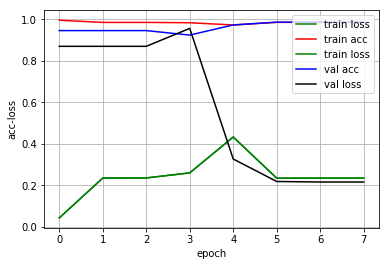

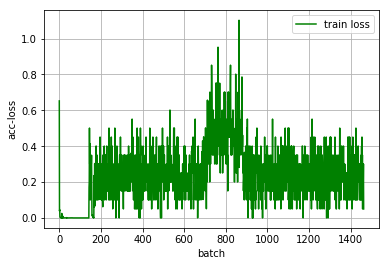

In [16]:
resnet(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Resnet: 98.652%

### Model 6: Inception

In [17]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
183/183 [==============================] - 163s 892ms/step - loss: 0.0315 - acc: 0.9909 - val_loss: 6.0914 - val_acc: 0.6161
Epoch 2/20
183/183 [==============================] - 92s 500ms/step - loss: 0.0144 - acc: 0.9932 - val_loss: 0.0021 - val_acc: 0.9997
Epoch 3/20
183/183 [==============================] - 93s 509ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 5.0573e-05 - val_acc: 1.0000
Epoch 4/20
183/183 [==============================] - 93s 506ms/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.2731 - val_acc: 0.9811
Epoch 5/20
183/183 [==============================] - 93s 507ms/step - loss: 3.6954e-04 - acc: 0.9999 - val_loss: 9.7136e-05 - val_acc: 0.9999
Epoch 00005: early stopping


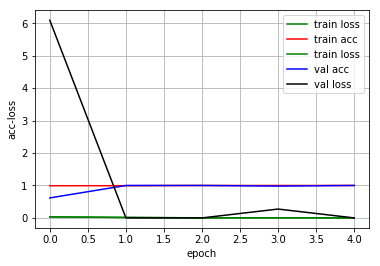

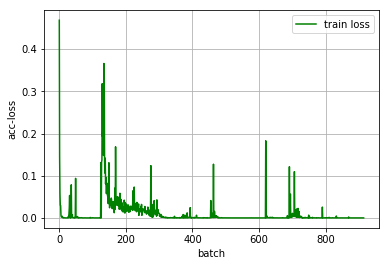

In [18]:
inception(num_class=5,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of Inception: 100.0%

### Model 7: InceptionResnet

In [19]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
183/183 [==============================] - 360s 2s/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.0172 - val_acc: 0.9954
Epoch 2/20
183/183 [==============================] - 134s 731ms/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0011 - val_acc: 0.9997
Epoch 3/20
183/183 [==============================] - 135s 739ms/step - loss: 2.7842e-04 - acc: 1.0000 - val_loss: 0.2168 - val_acc: 0.9864
Epoch 4/20
183/183 [==============================] - 137s 748ms/step - loss: 0.0022 - acc: 0.9998 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 5/20
183/183 [==============================] - 139s 761ms/step - loss: 6.1971e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 6/20
183/183 [==============================] - 140s 763ms/step - loss: 8.5028e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 00006: early stopping


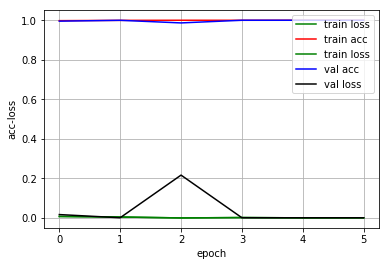

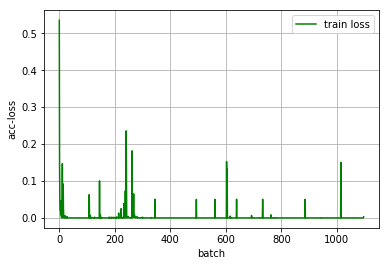

In [20]:
inceptionresnet(num_class=5,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

Validation accuracy of InceptionResnet: 99.993%

# Hyperparameter Optimization 
Use VGG16 as an example.  

Tuned hyperparameters of CNN: 
1. The number of frozen layers
2. The number of epochs
3. Early stop patience
4. Learning rate
5. Dropout rate

Hyperparameter optimization methods:
1. Random search
2. Bayesian optimization - Tree Parzen Estimator(BO-TPE)

In [6]:
def vgg16( num_class,epochs=20,frozen=15,lr=0.001,patience=2, dropout_rate=0.5,verbose=0, savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=patience, verbose=verbose, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
        verbose = verbose
    )
    return hist


In [7]:
def prediction(vgg_model):
#read images from validation folder
    rootdir = './test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

In [8]:
#define the objective function to be optimized
import time
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import matplotlib.pyplot as plt
import statistics 

def objective(params):
    
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen=params['frozen']
    epochs=params['epochs']
    patience=params['patience']
    lr=params['lr']
    dropout_rate=params['dropout_rate']

    vgg16(num_class=5, frozen=frozen,epochs=epochs,patience=patience, lr=lr, dropout_rate=dropout_rate)

    acc=prediction(vgg_model=load_model('./VGG16.h5'))

    print('accuracy:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }
    

In [9]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

accuracy:0.9322497861420017
accuracy:1.0
accuracy:1.0
accuracy:0.89803250641574
accuracy:0.8643284858853721
accuracy:1.0
accuracy:1.0
accuracy:1.0
accuracy:1.0
accuracy:1.0
100%|█████████████████████████████████████████████████████████████| 10/10 [58:16<00:00, 349.70s/trial, best loss: -1.0]
Hyperopt estimated optimum {'lr': 0.002, 'patience': 4.0, 'epochs': 15.0, 'dropout_rate': 0.4, 'frozen': 17.0}
Time: 3496.9893045425415


In [10]:
#Hyperparameter optimization by Random search
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.001, 0.006, 0.001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

accuracy:0.8643284858853721
accuracy:1.0
accuracy:0.9707442258340462
accuracy:1.0
accuracy:1.0
accuracy:1.0
accuracy:0.9615055603079555
accuracy:0.8643284858853721
accuracy:1.0
accuracy:0.8643284858853721
100%|███████████████████████████████████████████████████████████| 10/10 [1:04:57<00:00, 389.76s/trial, best loss: -1.0]
Hyperopt estimated optimum {'lr': 0.002, 'patience': 3.0, 'epochs': 15.0, 'dropout_rate': 0.6000000000000001, 'frozen': 16.0}
Time: 3897.5851550102234


In [11]:
# Retrain the model by using the best hyperparameter values to obtain the best model
vgg16(num_class=5, frozen=16,epochs=15,patience=3, lr=0.002, dropout_rate=0.6,verbose=1)

Epoch 1/15
183/183 [==============================] - 72s 395ms/step - loss: 0.0321 - acc: 0.9897 - val_loss: 9.1345e-07 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to ./VGG16.h5
Epoch 2/15
183/183 [==============================] - 70s 380ms/step - loss: 3.9581e-05 - acc: 1.0000 - val_loss: 3.1735e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/15
183/183 [==============================] - 70s 380ms/step - loss: 1.3703e-05 - acc: 1.0000 - val_loss: 1.7535e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/15
183/183 [==============================] - 70s 380ms/step - loss: 4.8536e-06 - acc: 1.0000 - val_loss: 2.1615e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 00004: early stopping
